In [1]:
import torch
from torch import nn

import numpy as np

from skimage import io
from torchvision.models import inception_v3
from torchvision import transforms, datasets

from PIL import Image
from matplotlib import pyplot as plt

from os import listdir
from os.path import isfile, join

import pickle

from rnn_decoder import RNNModel

In [2]:
TEST_IMAGES_PATH = '.\\rnn_test_images'

In [3]:
test_images = [join(TEST_IMAGES_PATH, f) for f in listdir(TEST_IMAGES_PATH) if isfile(join(TEST_IMAGES_PATH, f))]

In [4]:
f = open('vocabulary.pkl', 'rb')
vocab = pickle.load(f)

f = open('vocabulary_inverse.pkl', 'rb')
vocab_inverse = pickle.load(f)

In [5]:
decoder = RNNModel(
    'GRU', 
    ntoken=len(vocab), 
    ninp=RNNModel.WORD_EMBED_SIZE, 
    nhid=RNNModel.LSTM_UNITS, 
    nlayers=1,
    dropout=0).cuda()
decoder.load_state_dict(torch.load('decoder'))

<All keys matched successfully>

In [6]:
def generate(decoder, img_embeding, seqlen=50, temperature=0.25, debug=False):
    
    decoder.eval()
    
    generated = []
    
    x = torch.Tensor([[vocab['#START#']]]).long().cuda()    
    hidden = img_embeding.cuda()
    
    for i in range(seqlen):
        out, hidden = decoder(x, hidden)
        s_weights = out.squeeze().data.div(temperature).exp()
        s_idx = torch.multinomial(s_weights, 1)[0]
        x.data.fill_(s_idx)
        generated.append(vocab_inverse[int(s_idx)])
        
    if not debug:
        try:
            end_token_ix = generated.index('#END#')
        except ValueError:
            return ' '.join(generated)
        generated = ' '.join(generated[:end_token_ix])
        
    return generated

In [7]:
encoder = inception_v3(pretrained=True)
encoder.fc = nn.Identity()
encoder.eval()
encoder.to('cuda')

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [8]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
images = []
images_tensor = None

for impath in test_images:
    images.append(Image.open(impath))
    if images_tensor is None:
        images_tensor = preprocess(images[-1]).unsqueeze(0)
    else:
        images_tensor = torch.cat((images_tensor, preprocess(images[-1]).unsqueeze(0)))

In [10]:
embedded_images = encoder(images_tensor.cuda())

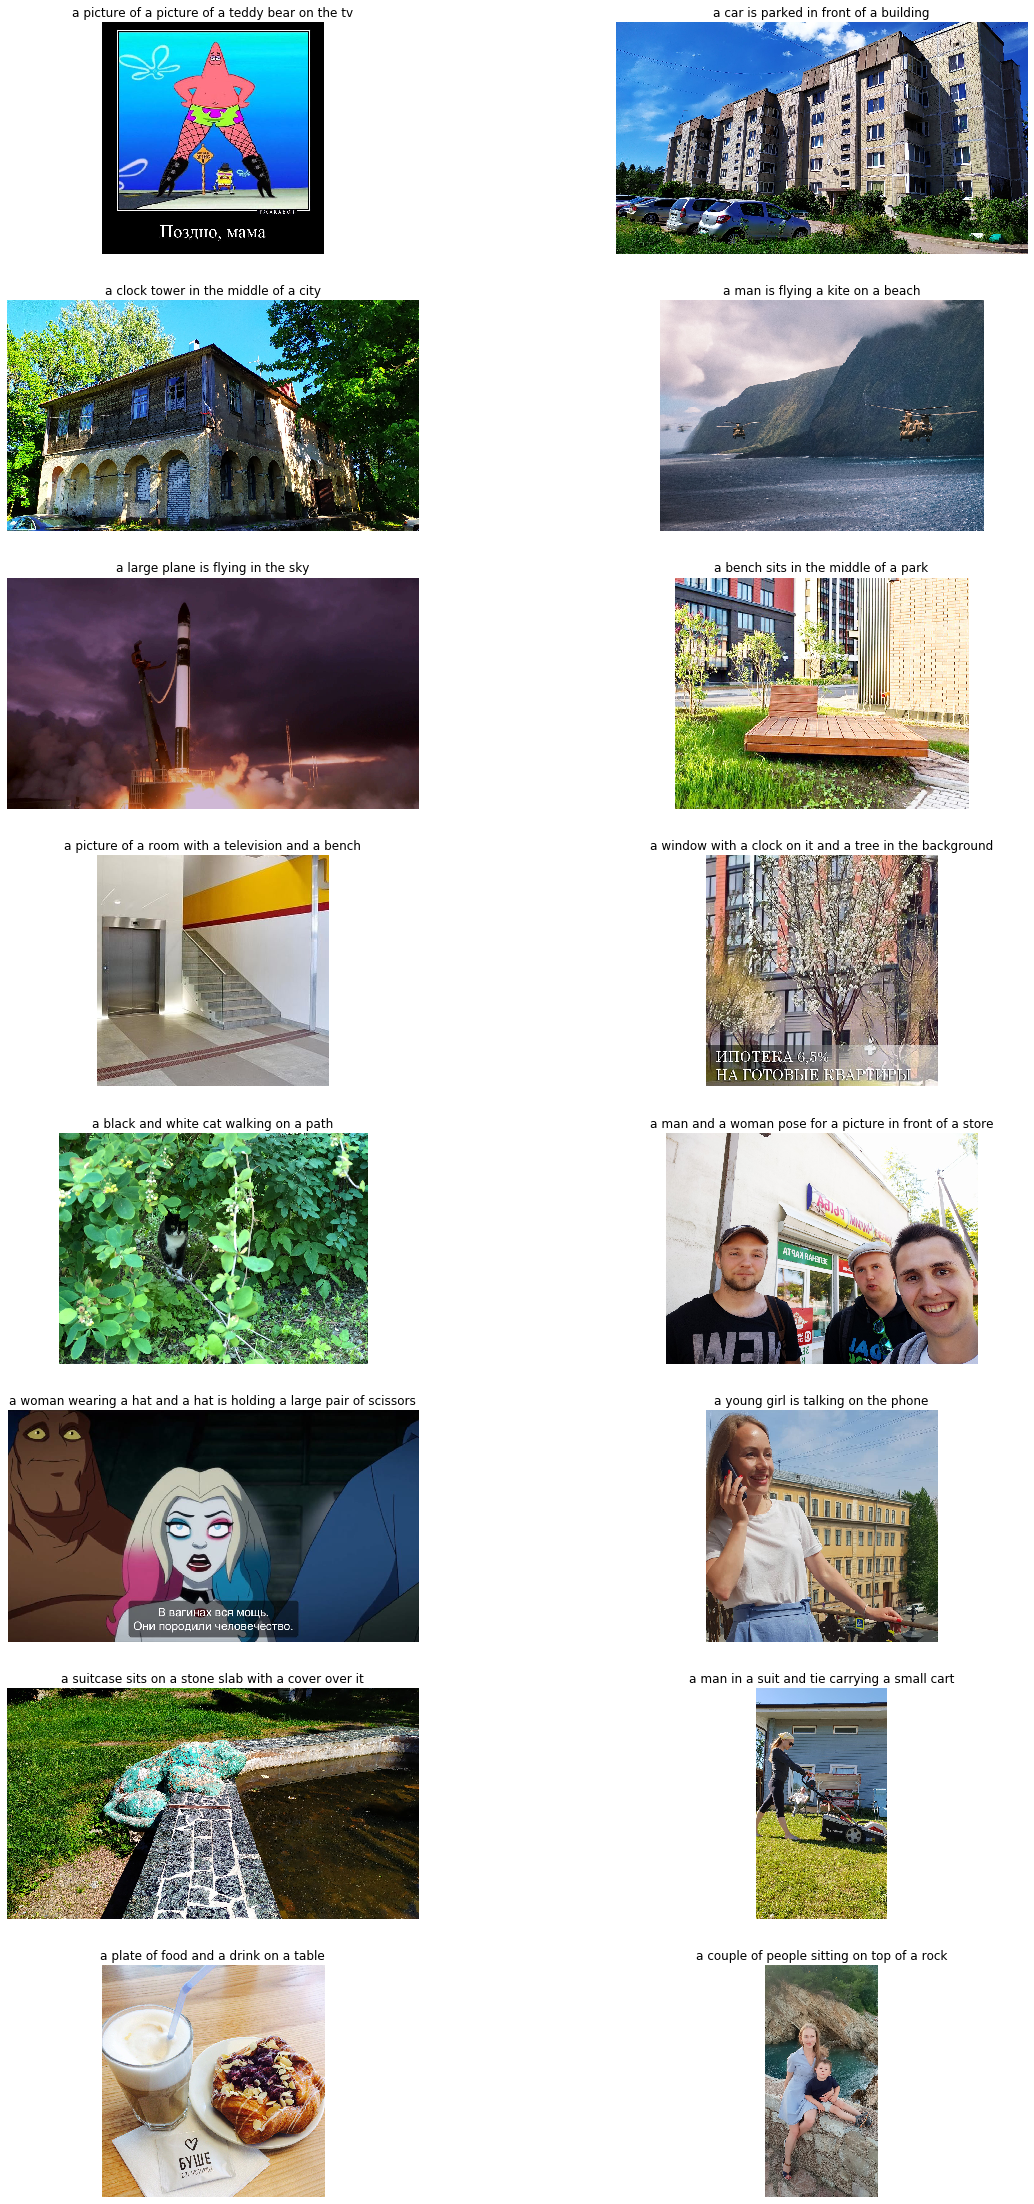

In [11]:
f = plt.figure(figsize=(20, 40))

IMAGES_PER_ROW = 2

for im_number, im in enumerate(images):
    f.add_subplot(np.ceil(len(images)/IMAGES_PER_ROW), IMAGES_PER_ROW, im_number+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title(generate(decoder, embedded_images[im_number].view(1,1,2048), temperature=.25))